In [90]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# import geopandas as gpd
# import contextily as cx

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve,\
    make_scorer

In [5]:
df_test = pd.read_csv('data/test_set_values.csv')
df_test

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011-02-24,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,...,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
14846,18990,1000.0,2011-03-21,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,...,annually,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
14847,28749,0.0,2013-03-04,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,...,never pay,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe
14848,33492,0.0,2013-02-18,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,...,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe


In [6]:
df_train = pd.read_csv('data/training_set_values.csv')
df_train

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [7]:
df_train_label = pd.read_csv('data/training_set_labels.csv')
df_train_label.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
df_train_label['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [9]:
target = df_train_label.replace({'status_group': {'functional' : 1, 
                                'non functional' : 0, 
                                'functional needs repair' : 0}})
target['status_group'].value_counts()

1    32259
0    27141
Name: status_group, dtype: int64

In [10]:
df = pd.concat([df_train, target], axis=1)
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,id,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,69572,1
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,8776,1
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,34310,1
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,67743,0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,19728,1


In [11]:
col_to_delete = ['id', 'recorded_by', 'funder', 'public_meeting',
                'lga', 'ward', 'region_code', 'district_code', 
                 'wpt_name','scheme_name', 'extraction_type', 'extraction_type_group',
                 'payment', 'quality_group', 'source_type', 'quantity_group',
                 'waterpoint_type_group', 'subvillage', 'num_private']
                 
df2 = df.drop(col_to_delete, axis=1)
df2.head()

,amount_tsh,date_recorded,gps_height,installer,longitude,latitude,basin,region,population,scheme_management,...,extraction_type_class,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group
0,6000.0,2011-03-14,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,109,VWC,...,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,1
1,0.0,2013-03-06,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,280,Other,...,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,1
2,25.0,2013-02-25,686,World vision,37.460664,-3.821329,Pangani,Manyara,250,VWC,...,gravity,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,1
3,0.0,2013-01-28,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,58,VWC,...,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,0
4,0.0,2011-07-13,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,0,NaN,...,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,1


In [12]:
print(df2.shape)

(59400, 22)


In [13]:
print(df2.duplicated().value_counts())

df2.drop_duplicates(keep='first',inplace=True)

False    58579
True       821
dtype: int64


<ipython-input-13-534793f6aba2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop_duplicates(keep='first',inplace=True)


In [14]:
df2.shape

(58579, 22)

In [15]:
df2 = df2.dropna(axis = 0)
df2.shape

(50545, 22)

In [16]:
df2['year_recorded'] = [int(val[0:4]) for val in df2['date_recorded']]
df2['year_recorded'].astype(np.int64)
df2.drop(['date_recorded'], axis='columns', inplace=True)
df2.head()

,amount_tsh,gps_height,installer,longitude,latitude,basin,region,population,scheme_management,permit,...,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group,year_recorded
0,6000.0,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,109,VWC,False,...,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,1,2011
1,0.0,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,280,Other,True,...,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,1,2013
2,25.0,686,World vision,37.460664,-3.821329,Pangani,Manyara,250,VWC,True,...,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,1,2013
3,0.0,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,58,VWC,True,...,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,0,2013
5,20.0,0,DWE,39.172796,-4.765587,Pangani,Tanga,1,VWC,True,...,vwc,user-group,per bucket,salty,enough,other,unknown,communal standpipe multiple,1,2011


In [17]:
df2['construction_year'] = ['unknown' if val == 0 
                           else str((val // 10) * 10) for val in df2['construction_year']]
df2['construction_year'].value_counts()

unknown    16240
2000       13800
1990        6420
1980        4993
2010        4519
1970        4113
1960         460
Name: construction_year, dtype: int64

In [18]:
scheme_management_list = ['SWC', 'Trust', 'None']
df2['scheme_management'].replace(scheme_management_list, 'Other', inplace=True)
df2['scheme_management'].value_counts()

VWC                 33542
WUG                  4539
Water authority      2942
WUA                  2656
Water Board          2527
Parastatal           1490
Private operator     1042
Company              1032
Other                 775
Name: scheme_management, dtype: int64

In [19]:
installer_list = ['DWE', 'Government', 'Commu', 'DANIDA', 
                  'RWE', 'KKKT', 'TCRS']
df2['installer'] = ['Other' if val not in installer_list 
                           else val for val in df2['installer']]
df2['installer'].value_counts()

Other         29476
DWE           14690
Government     1686
Commu          1060
DANIDA         1046
RWE            1025
KKKT            889
TCRS            673
Name: installer, dtype: int64

In [20]:
df2.drop(df2.index[df2['year_recorded'] == 2004], inplace=True)
df2.drop(df2.index[df2['year_recorded'] == 2002], inplace=True)
df2['year_recorded'].value_counts()

2011    24399
2013    20794
2012     5326
Name: year_recorded, dtype: int64

In [21]:
df2.reset_index(inplace=True, drop=True)
df2.head()

,amount_tsh,gps_height,installer,longitude,latitude,basin,region,population,scheme_management,permit,...,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group,year_recorded
0,6000.0,1390,Other,34.938093,-9.856322,Lake Nyasa,Iringa,109,VWC,False,...,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,1,2011
1,0.0,1399,Other,34.698766,-2.147466,Lake Victoria,Mara,280,Other,True,...,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,1,2013
2,25.0,686,Other,37.460664,-3.821329,Pangani,Manyara,250,VWC,True,...,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,1,2013
3,0.0,263,Other,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,58,VWC,True,...,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,0,2013
4,20.0,0,DWE,39.172796,-4.765587,Pangani,Tanga,1,VWC,True,...,vwc,user-group,per bucket,salty,enough,other,unknown,communal standpipe multiple,1,2011


In [22]:
def num_encoder(df_to_encode):
    ss = StandardScaler()

    ss.fit(df_to_encode)
    nums_df = pd.DataFrame(ss.transform(df_to_encode),
                           columns=df_to_encode.columns,
                          index=df_to_encode.index)
    return nums_df

def cat_encoder(df_to_encode):
    ohe = OneHotEncoder(
        drop='first',
        sparse=False)
    
    dums = ohe.fit_transform(df_to_encode)
    dums_df = pd.DataFrame(dums,
                            columns=ohe.get_feature_names(),
                            index=df_to_encode.index)
    return dums_df

In [23]:
y = df2.status_group
X = df2.drop('status_group', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

In [24]:
X_train_cat = X_train.select_dtypes('object')
X_train_nums = X_train.select_dtypes(['float64', 'int64'])

X_test_cat = X_test.select_dtypes('object')
X_test_nums = X_test.select_dtypes(['float64', 'int64'])

X_train_cat.shape, X_train_nums.shape, X_test_cat.shape, X_test_nums.shape

((37889, 15), (37889, 6), (12630, 15), (12630, 6))

In [25]:
cont_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])

trans = ColumnTransformer(transformers=[
    ('continuous', cont_pipeline, X_train_nums.columns),
    ('categorical', cat_pipeline, X_train_cat.columns)
])

dummy = Pipeline(steps=[
    ('trans', trans),
    ('dummy', DummyClassifier(random_state = 69, strategy = 'most_frequent'))
])

#Fitting and checking the score
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.5461215656259073

In [26]:
X_train_clean = pd.concat([num_encoder(X_train_nums), cat_encoder(X_train_cat)], axis=1)
X_test_clean = pd.concat([num_encoder(X_test_nums), cat_encoder(X_test_cat)], axis=1)

In [27]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, \
AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [28]:
decision_tree = DecisionTreeClassifier(random_state = 69)
decision_tree.fit(X_train_clean, y_train)

DecisionTreeClassifier(random_state=69)

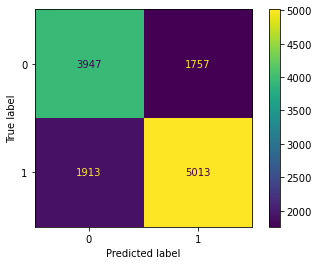

In [29]:
y_tree_train = decision_tree.predict(X_train_clean)
y_tree_test = decision_tree.predict(X_test_clean)
plot_confusion_matrix(decision_tree, X_test_clean, y_test);

In [30]:
display(accuracy_score(y_train, y_tree_train))
display(accuracy_score(y_test, y_tree_test))


0.9972287471297738

0.7094220110847189

In [31]:
display(precision_score(y_train, y_tree_train))

display(precision_score(y_test, y_tree_test))

0.99854700440742

0.7404726735598227

In [32]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_clean, y_train)

DecisionTreeClassifier()

In [33]:
param_dict = {
    "criterion":['gini', 'entropy'],
    "max_depth":[1, 10, 25, 50],
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,10)
}

In [34]:

# tw = GridSearchCV(estimator=decision_tree,
#                  param_grid=param_dict,
#                  cv=5,
#                  verbose=1,
#                  n_jobs=-1)
# tw.fit(X_train_clean, y_train)

In [35]:
# print(tw.best_params_)
# print(tw.best_estimator_)
# print(tw.best_score_)

Kept getting different `min_samples_split` value without results changing so it seems `criterion`, `max_depth`, & and `min_samples_leaf` give us a consistent enough result that `min_samples_split` does not need to be manipulated by us.

In [36]:
decision_tree_better = DecisionTreeClassifier(random_state = 69, criterion = 'gini', max_depth = 25, 
                                              min_samples_leaf = 7)
decision_tree_better.fit(X_train_clean, y_train)

DecisionTreeClassifier(max_depth=25, min_samples_leaf=7, random_state=69)

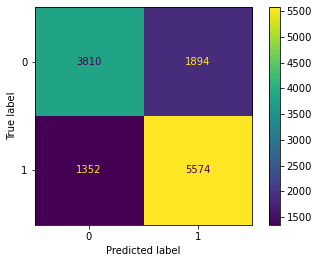

In [37]:
y_tree_train_better = decision_tree_better.predict(X_train_clean)
y_tree_test_better = decision_tree_better.predict(X_test_clean)
plot_confusion_matrix(decision_tree_better, X_test_clean, y_test);

In [38]:
display(accuracy_score(y_train, y_tree_train_better))
display(precision_score(y_train, y_tree_train_better))

0.8751616564174298

0.8781030888762554

In [39]:
display(accuracy_score(y_test, y_tree_test_better))
display(precision_score(y_test, y_tree_test_better))

0.7429928741092636

0.7463845741831816

In [40]:
# y_tt_clean = decision_tree_better.predict(X_tt_clean)

---

[1.52702679e-02 7.10429815e-02 1.37210267e-01 1.36674882e-01
 4.68261190e-02 9.53657472e-03 1.29306388e-03 1.05856439e-02
 5.62939918e-03 8.51355576e-04 1.12309537e-02 3.02187266e-03
 1.44444540e-03 5.89919931e-03 3.51626916e-03 4.66321932e-03
 4.73777466e-03 5.54219662e-03 4.75242980e-03 3.73372449e-03
 4.98469521e-03 1.00559237e-03 2.57531447e-03 9.39707128e-03
 2.67249167e-03 2.74083687e-03 3.42923966e-03 1.72002295e-03
 2.59232272e-03 1.97153976e-03 2.55216059e-03 2.36958428e-03
 2.47362047e-03 2.19133280e-03 2.94474599e-03 2.16491533e-03
 2.39889007e-03 2.10332787e-03 1.53043643e-03 1.77788446e-03
 2.90876681e-03 1.42777673e-03 1.26264590e-03 1.46109363e-03
 6.75932603e-03 2.41794491e-03 2.76298245e-03 3.78843454e-03
 3.49718680e-03 1.40794450e-02 9.93670705e-03 7.27509264e-03
 7.57283824e-03 1.25819110e-02 1.25509518e-02 5.68369806e-03
 9.99352734e-03 3.95989370e-03 2.35169773e-02 8.77119960e-04
 7.62816449e-03 4.61477504e-04 8.15650635e-04 1.93682196e-04
 1.31728710e-03 2.832842

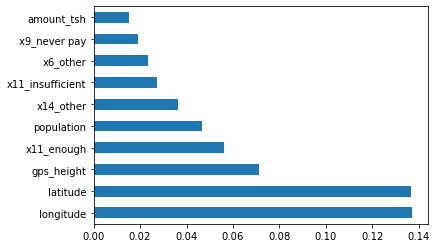

In [41]:
model = ExtraTreesClassifier()
model.fit(X_train_clean,y_train)

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_clean.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [42]:
X_train_cat.columns

Index(['installer', 'basin', 'region', 'scheme_management', 'permit',
       'construction_year', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'water_quality', 'quantity',
       'source', 'source_class', 'waterpoint_type'],
      dtype='object')

In [43]:
df2['waterpoint_type'].value_counts()

communal standpipe             25019
hand pump                      14022
communal standpipe multiple     5854
other                           4874
improved spring                  661
cattle trough                     83
dam                                6
Name: waterpoint_type, dtype: int64

In [44]:
importance_col = ['longitude', 'latitude', 'gps_height', 'quantity', 
                  'status_group', 'population', 'waterpoint_type', 
                 'extraction_type_class', 'payment_type', 'amount_tsh']
df_importance = df2[importance_col]

In [45]:
y2 = df_importance.status_group
X2 = df_importance.drop('status_group', axis=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, random_state=69)

In [46]:
X_train_cat2 = X_train2.select_dtypes('object')
X_train_nums2 = X_train2.select_dtypes(['float64', 'int64'])

X_test_cat2 = X_test2.select_dtypes('object')
X_test_nums2 = X_test2.select_dtypes(['float64', 'int64'])

In [47]:
X_train_clean2 = pd.concat([num_encoder(X_train_nums2), cat_encoder(X_train_cat2)], axis=1)
X_test_clean2 = pd.concat([num_encoder(X_test_nums2), cat_encoder(X_test_cat2)], axis=1)

In [48]:
logreg_clf2 = LogisticRegression(random_state=69, max_iter=1000)
logreg_model2 = logreg_clf2.fit(X_train_clean2, y_train2)

In [49]:
logreg_train_pred2 = logreg_clf2.predict(X_train_clean2)
logreg_train_acc2 = accuracy_score(y_train2, logreg_train_pred2)

log_val_preds2 = logreg_clf2.predict(X_test_clean2) # y_hat
log_val_accuracy2 = accuracy_score(y_test2, log_val_preds2)

logreg_train_acc2, log_val_accuracy2

(0.7304758637071446, 0.7315122723673793)

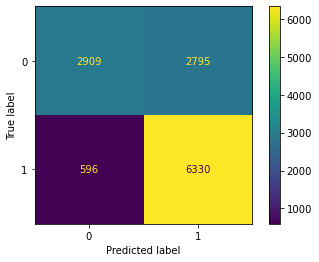

In [50]:
plot_confusion_matrix(logreg_clf2, X_test_clean2, y_test2);

In [51]:
display(precision_score(y_train2, logreg_train_pred2))

display(precision_score(y_test2, log_val_preds2))

0.6916325336454067

0.6936986301369863

---

In [52]:
logreg_clf = LogisticRegression(random_state=69, max_iter=1000)
logreg_model = logreg_clf.fit(X_train_clean, y_train)

In [53]:
logreg_train_pred = logreg_clf.predict(X_train_clean)
logreg_train_acc = accuracy_score(y_train, logreg_train_pred)

log_val_preds = logreg_clf.predict(X_test_clean) # y_hat
log_val_accuracy = accuracy_score(y_test, log_val_preds)

logreg_train_acc, log_val_accuracy

(0.7625168254638549, 0.7629453681710214)

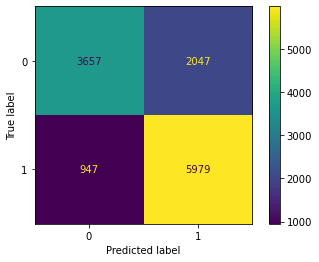

In [54]:
plot_confusion_matrix(logreg_clf, X_test_clean, y_test);

In [55]:
display(precision_score(y_train, logreg_train_pred))

display(precision_score(y_test, log_val_preds))

0.7457135653050933

0.7449538998255669

In [56]:
from sklearn.neighbors import KNeighborsClassifier

In [57]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_clean, y_train)
grid = {
    'n_neighbors': range(1, 15),
    'metric': ['manhattan'],
    'weights' : ['distance']
}

In [58]:
# gs = GridSearchCV(estimator = knn_model, param_grid = grid, cv = 5, verbose = 1, n_jobs = -1)
# gs.fit(X_train_clean, y_train)

In [59]:
# gs.best_params_

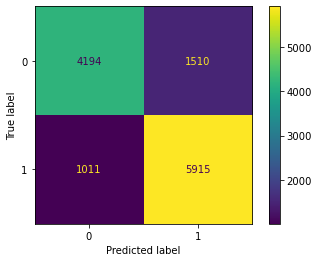

In [60]:
knn_better = KNeighborsClassifier(14, metric = "manhattan", weights = 'distance') 
knn_better.fit(X_train_clean, y_train)

y_knn_better_train = knn_better.predict(X_train_clean)
y_knn_better_test = knn_better.predict(X_test_clean)

plot_confusion_matrix(knn_better, X_test_clean, y_test);

In [61]:
display(accuracy_score(y_train, y_knn_better_train))
display(precision_score(y_train, y_knn_better_train))

0.9972287471297738

0.99854700440742

In [62]:
display(accuracy_score(y_test, y_knn_better_test))
display(precision_score(y_test, y_knn_better_test))

0.8003958828186857

0.7966329966329966

In [63]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor


avg = VotingClassifier(estimators=[ ('lr', logreg_model),
                                    ('dt', decision_tree_better),
                                    ('knn', knn_better)],
                                     weights=[0.25, 0.25, 0.5])
avg.fit(X_train_clean, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=69)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=25,
                                                     min_samples_leaf=7,
                                                     random_state=69)),
                             ('knn',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=14,
                                                   weights='distance'))],
                 weights=[0.25, 0.25, 0.5])

In [64]:
scores = cross_val_score(estimator=avg, X=X_train_clean, y=y_train, cv=5)
scores

array([0.80430193, 0.80509369, 0.80984429, 0.79638427, 0.79516959])

In [65]:
np.median(scores)

0.8043019266297176

In [66]:
avg.score(X_test_clean, y_test)

0.8064133016627079

In [67]:
print("Acc:", accuracy_score(y_test, avg.predict(X_test_clean)))
print("Prec: ", precision_score(y_test, avg.predict(X_test_clean)))

Acc: 0.8064133016627079
Prec:  0.8164101115661629


---

In [68]:
df3 = df_test.drop(col_to_delete, axis=1)
df3.head()

,amount_tsh,date_recorded,gps_height,installer,longitude,latitude,basin,region,population,scheme_management,...,construction_year,extraction_type_class,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type
0,0.0,2013-02-04,1996,DMDD,35.290799,-4.059696,Internal,Manyara,321,Parastatal,...,2012,other,parastatal,parastatal,never pay,soft,seasonal,rainwater harvesting,surface,other
1,0.0,2013-02-04,1569,DWE,36.656709,-3.309214,Pangani,Arusha,300,VWC,...,2000,gravity,vwc,user-group,never pay,soft,insufficient,spring,groundwater,communal standpipe
2,0.0,2013-02-01,1567,NaN,34.767863,-5.004344,Internal,Singida,500,VWC,...,2010,other,vwc,user-group,never pay,soft,insufficient,rainwater harvesting,surface,other
3,0.0,2013-01-22,267,FINN WATER,38.058046,-9.418672,Ruvuma / Southern Coast,Lindi,250,VWC,...,1987,other,vwc,user-group,unknown,soft,dry,shallow well,groundwater,other
4,500.0,2013-03-27,1260,BRUDER,35.006123,-10.950412,Ruvuma / Southern Coast,Ruvuma,60,Water Board,...,2000,gravity,water board,user-group,monthly,soft,enough,spring,groundwater,communal standpipe


In [69]:
print(df3.duplicated().value_counts())
df3.drop_duplicates(keep='first',inplace=True)

False    14749
True       101
dtype: int64


In [70]:
df3 = df3.dropna(axis = 0)

In [71]:
df3['year_recorded'] = [int(val[0:4]) for val in df3['date_recorded']]
df3['year_recorded'].astype(np.int64)
df3.drop(['date_recorded'], axis='columns', inplace=True)

In [72]:
df3['construction_year'] = ['unknown' if val == 0 
                           else str((val // 10) * 10) for val in df3['construction_year']]

In [73]:
df3['scheme_management'].replace(scheme_management_list, 'Other', inplace=True)

In [74]:
df3['installer'] = ['Other' if val not in installer_list 
                           else val for val in df3['installer']]

In [75]:
df3.drop(df3.index[df3['year_recorded'] < 2005], inplace=True)

In [76]:
Ftest_cat = df3.select_dtypes('object')
Ftest_nums = df3.select_dtypes(['float64', 'int64'])

In [77]:
Ftest = pd.concat([num_encoder(Ftest_nums), cat_encoder(Ftest_cat)], axis=1)

In [78]:
df3['targets'] = avg.predict(Ftest)

In [79]:
df3.head()

,amount_tsh,gps_height,installer,longitude,latitude,basin,region,population,scheme_management,permit,...,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,year_recorded,targets
0,0.0,1996,Other,35.290799,-4.059696,Internal,Manyara,321,Parastatal,True,...,parastatal,parastatal,never pay,soft,seasonal,rainwater harvesting,surface,other,2013,1
1,0.0,1569,DWE,36.656709,-3.309214,Pangani,Arusha,300,VWC,True,...,vwc,user-group,never pay,soft,insufficient,spring,groundwater,communal standpipe,2013,1
3,0.0,267,Other,38.058046,-9.418672,Ruvuma / Southern Coast,Lindi,250,VWC,True,...,vwc,user-group,unknown,soft,dry,shallow well,groundwater,other,2013,0
4,500.0,1260,Other,35.006123,-10.950412,Ruvuma / Southern Coast,Ruvuma,60,Water Board,True,...,water board,user-group,monthly,soft,enough,spring,groundwater,communal standpipe,2013,1
5,0.0,1685,DWE,36.685279,-3.302420,Pangani,Arusha,200,VWC,True,...,vwc,user-group,never pay,soft,enough,spring,groundwater,communal standpipe,2013,1


Combined 0 and 1

In [89]:
# drop_zeros = df3.loc[(df3['longitude'] != 0.0) & (df3['latitude'] != 0.0)]

# fig, ax = plt.subplots(figsize=(18,12))

# countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# drop_zeros
# sns.scatterplot(x = drop_zeros['longitude'], y = drop_zeros['latitude'], hue = drop_zeros["targets"], \
#                 palette = ["red", "blue"], alpha = .5)

# ax.grid(b=True, alpha=0.5)

# cx.add_basemap(ax, crs=countries.crs.to_string())

# ax.set(title='Combined Wells, 0 = Broken, 1 = Working')

# plt.show()

# fig.savefig("combo.png")

# Appendix

Need Repair

In [87]:
# temp_0 = df3.loc[(df3['longitude'] != 0.0) & (df3['latitude'] != 0.0)]


# temp_00 = temp_0.loc[(df3['targets'] == 0)]

# dropper = temp_00

# fig, ax = plt.subplots(figsize=(18,12))

# countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# sns.scatterplot(x = dropper['longitude'], y = dropper['latitude'], color = "red", alpha = .5)

# ax.grid(b=True, alpha=0.5)

# cx.add_basemap(ax, crs=countries.crs.to_string())
# ax.set(title='Need Repair')


# plt.show()
# fig.savefig("need_repair.png")

Functional Wells

In [88]:
# temp_1 = df3.loc[(df3['longitude'] != 0.0) & (df3['latitude'] != 0.0)]


# temp_11 = temp_1.loc[(df3['targets'] == 1)]

# dropper_1 = temp_11

# fig, ax = plt.subplots(figsize=(18,12))

# countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


# sns.scatterplot(x = dropper_1['longitude'], y = dropper_1['latitude'], color = "blue", alpha = .5)

# ax.grid(b=True, alpha=0.5)

# cx.add_basemap(ax, crs=countries.crs.to_string())

# ax.set(title='Functioning Wells')

# plt.show()

 
# fig.savefig("working.png")